In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import sympy

import def_all_CRNs as CRNs

from dae_finder import (
        AlgModelFinder,
        PolyFeatureMatrix,
        add_noise_to_df,
        get_refined_lib,
        sequentialThLin,
        smooth_data,
)

import pysindy

In [5]:
x_train.shape

(4002, 1)

### Discovery of Algebraic Relationships

In [102]:
num_points = 1200
noise_perc = 1
t_final = 4

In [103]:
# 1) Make data
clean_data = CRNs.make_CRN1(5, num_points, t_final)
clean_df = pd.DataFrame(clean_data, columns=['t', 'A', 'B', 'E1', 'AE1'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

tSolve = list(data_matrix_df_list[0]['t'])
num_time_points = len(tSolve)

# 2) Noise data
for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["t"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=8) # Use trial as RNG seed
        noisy_data_df["t"] = t_exact
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)

data_matrix_features = data_matrix_df_list[0].columns

# 3) Smooth noisy data
data_matrix_smooth_df_list = [
    smooth_data(data_matrix[:num_points],
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=1,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in data_matrix_df_list]

if len(data_matrix_smooth_df_list) == 1:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[['A', 'B', 'E1', 'AE1']]


In [104]:
# data_matrix_df_new.to_csv("data_matrix_df_incorrect_5_percent_2_degree.csv", index=False)
# data_matrix_df_list[0].to_csv("data_matrix_df_incorrect_5_percent_2_degree_1.csv", index=False)

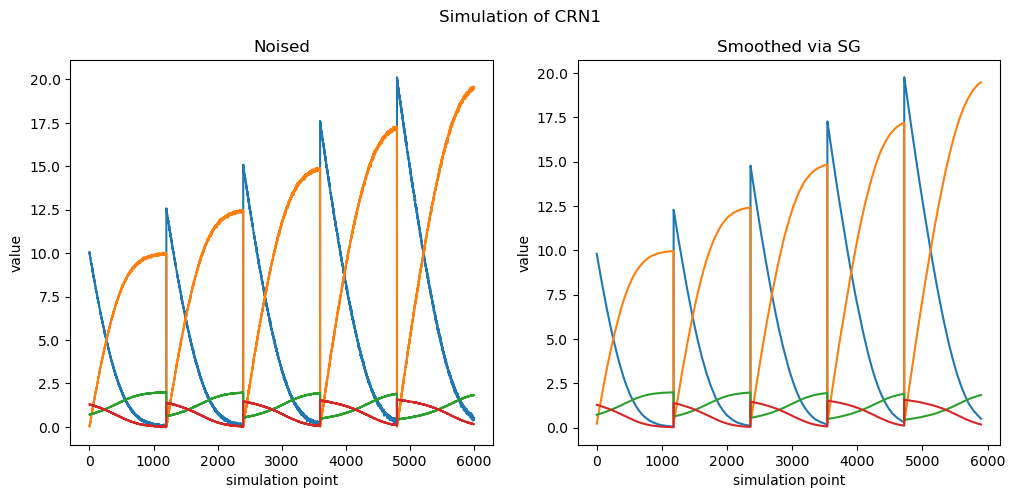

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].plot(data_matrix_df_appended.drop('t', axis=1))
axes[0].set_title("Noised")

axes[1].plot(data_matrix_df_new)
axes[1].set_title("Smoothed via SG")

axes[0].set_xlabel("simulation point")
axes[1].set_xlabel("simulation point")

axes[0].set_ylabel("value")
axes[1].set_ylabel("value")

# Shared title
fig.suptitle("Simulation of CRN1")

# Show the plot
plt.show()

In [106]:
# 4) Make lib
poly_degree = 2

poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))
print("Full candidate library has the following features: {}".format(list(candidate_lib_full.columns)))

Degree of library: 2
# terms in the library: 14
Full candidate library has the following features: ['A', 'B', 'E1', 'AE1', 'A^2', 'A B', 'A E1', 'A AE1', 'B^2', 'B E1', 'B AE1', 'E1^2', 'E1 AE1', 'AE1^2']


In [107]:
# 5) Make feats
feat_list = ['A', 'B', 'E1', 'AE1']
feat_list_str = ", ".join(feat_list)
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

# Importing SINDI-PI related modules from pysindy

In [108]:
# Import libraries.
import numpy as np
import math 
# np.math = math
from matplotlib import pyplot as plt
import pysindy as ps
from pysindy.differentiation import FiniteDifference
from pysindy.utils import enzyme, bacterial
import sympy as sp
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score

# For reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [109]:
data_matrix_df_list[0]['B'].values.reshape(-1, 1).shape

(1200, 1)

In [110]:
data_matrix_df_list[0]['t'].values.reshape(-1,1)

array([[0.00000000e+00],
       [3.33611343e-03],
       [6.67222686e-03],
       ...,
       [3.99332777e+00],
       [3.99666389e+00],
       [4.00000000e+00]], shape=(1200, 1))

In [111]:
data_matrix_df_list[0]['t'].values

array([0.00000000e+00, 3.33611343e-03, 6.67222686e-03, ...,
       3.99332777e+00, 3.99666389e+00, 4.00000000e+00], shape=(1200,))

In [112]:
len(t)

1200

In [124]:
# define parameters
r = 1
dt = data_matrix_df_list[0]['t'][1] - data_matrix_df_list[0]['t'][0]
T = 4
# t = np.arange(0, T+dt, dt)
t = data_matrix_df_list[0]['t'].values
# t = [data_matrix_df_list[ind]['t'].values for ind in range(len(data_matrix_df_list))]

t_span = (0, 4)
x0_train = [0.55]
# x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T
x_train = [data_matrix_df_list[ind]['A'].values.reshape(-1, 1) for ind in range(len(data_matrix_df_list))]

# Initialize custom SINDy library so that we can have x_dot inside it.
library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    # lambda x: x ** 3,
    # lambda x, y, z, w: x * y * z * w,
    # lambda x, y, z: x * y * z ** 2,
    # lambda x, y: x * y ** 3,
    # lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both
# the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    # lambda x: x + x + x,
    # lambda x, y, z, w: x + y + z + w,
    # lambda x, y, z: x + y + z + z,
    # lambda x, y: x + y + y + y,
    # lambda x: x + x + x + x,
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t,
    function_names=library_function_names,
    include_bias=True,
)
# sindy_library = ps.PDELibrary(
#     function_library=library_functions,
#     temporal_grid=t.reshape(-1,),
#     # function_names=library_function_names,
#     include_bias=True,
#     implicit_terms=True,
#     derivative_order=1
# )
# sindy_opt = ps.SINDyPI(
#     threshold=1e-6,
#     tol=1e-8,
#     thresholder="l1",
#     max_iter=20000,
# )
sindy_opt = ps.optimizers.SINDyPI()

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.SmoothedFiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
# model.fit([x_train, x_train], t=[t,t])

model.print()

sindy_library.get_feature_names()


/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/pysindy/feature_library/sindy_pi_library.py:146: UserWarning: This library is deprecated in PySINDy versions > 1.7. Please use the PDE or WeakPDE libraries instead. 
  warnings.warn(


Model  0
Model  1
Model  2
Model  3
Model  4
Model  5
(1) = 0.371 x0 + -0.021 x0x0 + -0.120 x0_dot + 0.045 x0x0_dot + -0.003 x0x0x0_dot
(x0) = 1.185 1 + 0.066 x0x0 + 0.085 x0_dot + -0.116 x0x0_dot + 0.008 x0x0x0_dot
(x0x0) = -13.404 1 + 13.231 x0 + -0.668 x0_dot + 1.447 x0x0_dot + -0.112 x0x0x0_dot
(x0_dot) = -1.375 1 + 0.305 x0 + -0.012 x0x0 + 0.211 x0x0_dot + -0.009 x0x0x0_dot
(x0x0_dot) = 5.308 1 + -4.266 x0 + 0.266 x0x0 + 2.167 x0_dot + 0.057 x0x0x0_dot
(x0x0x0_dot) = nan 1 + nan x0 + nan x0x0 + nan x0_dot + nan x0x0_dot + nan x0x0x0_dot


/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/pysindy/optimizers/sindy_pi.py:151: ConvergenceWarning: Infeasible solve on iteration 5, try changing your library
  warnings.warn(


['1', 'x0', 'x0x0', 'x0_dot', 'x0x0_dot', 'x0x0x0_dot']

In [122]:
model.score(x_train, t=t,)

ValueError: Input contains NaN.